<a href="https://colab.research.google.com/github/victorkingbuilder/Flocking_ProjectResearch/blob/main/OAFA_Newest_Study_with_Simple_Optimizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy, gaussian_kde
from sklearn.cluster import MiniBatchKMeans
import time
from sklearn.metrics import silhouette_score, adjusted_rand_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import functools # Import functools for partial function application

!pip install scikit-optimize==0.9.0
# Import skopt for Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args # For cleaner objective function definition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.1 MB/s eta 0:00:00


In [3]:
# =============================================================================
# --- Core Simulation Definitions (Bird, Model, Utility & Thermodynamic Functions) ---
# =============================================================================

class Bird:
    """
    Represents a single bird agent in the flocking simulation, extended for OAFA.
    Includes adaptive rule weights and history for local entropy calculation.
    """
    def __init__(self, pos, vel, speed, cohere_factor, separation,
                 separate_factor, match_factor, visual_distance, ensemble, history_length,
                 # OAFA specific additions
                 w_cohere_init, w_separation_init, w_alignment_init,
                 local_entropy_history_length=10):
        self.pos = np.array(pos, dtype=np.float64)
        self.vel = np.array(vel, dtype=np.float64)
        norm_vel = np.linalg.norm(self.vel)
        self.vel = self.vel / norm_vel if norm_vel > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.cohere_factor = cohere_factor # Base factor, now multiplied by adaptive weight
        self.separation = separation       # Base factor
        self.separate_factor = separate_factor # Base factor, now multiplied by adaptive weight
        self.match_factor = match_factor   # Base factor, now multiplied by adaptive weight
        self.visual_distance = visual_distance
        self.ensemble = ensemble # Local 'energy' or 'state' (from previous study)
        self.ensemble_history = deque(maxlen=history_length)

        # OAFA: Adaptive Rule Weights (agent-specific)
        self.w_cohere = w_cohere_init
        self.w_separation = w_separation_init
        self.w_alignment = w_alignment_init

        # OAFA: History for local directional entropy calculation
        self.velocity_history = deque(maxlen=local_entropy_history_length)

class Predator:
    """
    Represents a predator agent.
    """
    def __init__(self, pos, speed, extent, rng):
        self.pos = np.array(pos, dtype=np.float64)
        # Simple random walk velocity for predator
        self.vel = rng.uniform(-1, 1, size=2)
        self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.extent = extent
        self.rng = rng

    def move(self):
        """Moves the predator and applies periodic boundary conditions."""
        self.pos += self.vel * self.speed
        self.pos[0] %= self.extent[0]
        self.pos[1] %= self.extent[1]
        # Occasionally change direction slightly
        if self.rng.random() < 0.1: # 10% chance to slightly alter course
            angle_change = self.rng.uniform(-np.pi/4, np.pi/4) # +/- 45 degrees
            rotation_matrix = np.array([[np.cos(angle_change), -np.sin(angle_change)],
                                        [np.sin(angle_change),  np.cos(angle_change)]])
            self.vel = np.dot(self.vel, rotation_matrix)
            self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])


class Model:
    """
    Represents the overall flocking simulation environment, extended for OAFA.
    Manages birds and predators, and OAFA-specific adaptive parameters.
    Includes an 'optimization_mode' for simplified runs.
    """
    def __init__(self, n_birds=100, speed=2.0, cohere_factor=0.4, separation=4.0,
                 separate_factor=0.25, match_factor=0.02, visual_distance=5.0,
                 ensemble=1, history_length=8, extent=(50, 50), seed=1234,
                 # OAFA specific parameters
                 w_cohere_init=0.5, w_separation_init=1.0, w_alignment_init=0.5,
                 oafa_learning_rate_eta=0.01, oafa_stochastic_epsilon_range=0.1,
                 num_predators=0, predator_speed=1.5, predator_detection_radius=10.0,
                 local_entropy_history_length=10, dt=1.0,

                 # Parameters for simplified optimization mode
                 optimization_mode=False, n_birds_opt=30, total_steps_opt=50):

        self.iteration = 0
        self.extent = extent
        self.agents = []
        self.predators = []
        self.rng = np.random.default_rng(seed)

        # OAFA parameters
        self.oafa_learning_rate_eta = oafa_learning_rate_eta
        self.oafa_stochastic_epsilon_range = oafa_stochastic_epsilon_range
        self.predator_detection_radius = predator_detection_radius
        self.dt = dt # Time step for the simulation

        # Adjust parameters if in optimization mode for faster evaluations
        if optimization_mode:
            self.n_birds = n_birds_opt
            self.num_predators = min(num_predators, 1) # Limit predators to 1 for optimization
            self.predator_speed = predator_speed # Keep predator speed as is
            self.visual_distance = visual_distance # Keep visual distance
        else: # Full simulation mode
            self.n_birds = n_birds
            self.num_predators = num_predators
            self.predator_speed = predator_speed
            self.visual_distance = visual_distance


        # Initialize birds
        for _ in range(self.n_birds): # Use self.n_birds which might be adjusted
            vel = self.rng.uniform(-1, 1, size=2)
            if np.linalg.norm(vel) == 0:
                vel = np.array([1.0, 0.0])
            else:
                vel = vel / np.linalg.norm(vel)
            pos = self.rng.uniform(low=[0, 0], high=extent, size=2)
            bird = Bird(pos, vel, speed, cohere_factor, separation,
                        separate_factor, match_factor, visual_distance,
                        ensemble, history_length,
                        w_cohere_init, w_separation_init, w_alignment_init,
                        local_entropy_history_length)
            self.agents.append(bird)

        # Initialize predators
        for _ in range(self.num_predators): # Use self.num_predators which might be adjusted
            pred_pos = self.rng.uniform(low=[0, 0], high=extent, size=2)
            predator = Predator(pred_pos, predator_speed, extent, self.rng)
            self.predators.append(predator)

def move_agent(agent, model):
    """Moves the agent and applies periodic boundary conditions."""
    agent.pos += agent.vel * agent.speed * model.dt # Scale by dt
    agent.pos[0] %= model.extent[0]
    agent.pos[1] %= model.extent[1]

def get_neighbors(agent, model, radius):
    """Returns a list of agents within the specified radius (excluding self)."""
    neighbors = []
    for other in model.agents:
        if other is agent:
            continue
        if np.linalg.norm(agent.pos - other.pos) < radius:
            neighbors.append(other)
    return neighbors

def calculate_directional_entropy(velocities, num_bins=8):
    """
    Calculates the directional entropy of a set of 2D velocity vectors.
    Bins are angular sectors (e.g., 8 bins for 45-degree sectors).
    """
    if len(velocities) < 2: # Need at least 2 velocities to form a distribution
        return 0.0

    # Filter out zero-magnitude velocities to avoid issues with arctan2
    non_zero_velocities = velocities[np.linalg.norm(velocities, axis=1) > 1e-9]

    if len(non_zero_velocities) < 2:
        return 0.0

    angles = np.arctan2(non_zero_velocities[:, 1], non_zero_velocities[:, 0]) # Angles in radians (-pi to pi)

    # Normalize angles to [0, 2*pi) for histogramming
    angles = (angles + 2 * np.pi) % (2 * np.pi)

    # Create histogram of angles
    counts, _ = np.histogram(angles, bins=num_bins, range=(0, 2 * np.pi))

    # Convert counts to probabilities, handling sum=0 if all counts are 0
    total_counts = np.sum(counts)
    if total_counts == 0:
        return 0.0
    probabilities = counts / total_counts

    # Calculate Shannon entropy, handling 0 probabilities correctly with scipy.stats.entropy
    return entropy(probabilities)


def agent_step(agent, model):
    """
    Updates an individual agent's velocity based on OAFA rules (cohesion, separation, alignment, predator avoidance)
    and dynamically adjusts rule weights based on local entropy feedback.
    """
    neighbors = get_neighbors(agent, model, agent.visual_distance)

    cohere_force = np.array([0.0, 0.0])
    separate_force = np.array([0.0, 0.0])
    match_force = np.array([0.0, 0.0])
    predator_avoidance_force = np.array([0.0, 0.0])

    N_neighbors = max(len(neighbors), 1)

    # Calculate Boids forces
    if N_neighbors > 0:
        # Cohesion: move towards centroid of neighbors
        cohere_force = (np.sum([n.pos for n in neighbors], axis=0) / N_neighbors) - agent.pos

        # Separation: move away from close neighbors
        for neighbor in neighbors:
            heading = agent.pos - neighbor.pos
            distance = np.linalg.norm(heading)
            if distance < agent.separation:
                separate_force += heading / (distance**2 + 1e-9) # Inverse square law repulsion

        # Alignment: match velocity of neighbors
        match_force = (np.sum([n.vel for n in neighbors], axis=0) / N_neighbors) - agent.vel

    # Calculate Predator Avoidance Force
    for predator in model.predators:
        vec_to_predator = agent.pos - predator.pos
        dist_to_predator = np.linalg.norm(vec_to_predator)
        if dist_to_predator < model.predator_detection_radius:
            predator_avoidance_force += vec_to_predator / (dist_to_predator**2 + 1e-9)

    # Apply OAFA adaptive weights to forces
    # The original factors (cohere_factor, separate_factor, match_factor)
    # are now multiplied by the agent's adaptive weights.
    weighted_cohere = cohere_force * agent.w_cohere * agent.cohere_factor
    weighted_separate = separate_force * agent.w_separation * agent.separate_factor
    weighted_match = match_force * agent.w_alignment * agent.match_factor

    # Combine all forces
    new_vel_direction = (agent.vel + weighted_cohere + weighted_separate + weighted_match + predator_avoidance_force)

    # Normalize the new velocity direction to maintain constant speed (or apply speed limit)
    norm_new_vel = np.linalg.norm(new_vel_direction)
    agent.vel = new_vel_direction / norm_new_vel if norm_new_vel > 0 else agent.vel

    move_agent(agent, model)

    # OAFA: Update local entropy history and adapt rule weights
    agent.velocity_history.append(agent.vel)

    # Calculate local directional entropy for the agent
    if len(agent.velocity_history) > 1:
        local_velocities = np.array(list(agent.velocity_history))
        current_local_entropy = calculate_directional_entropy(local_velocities)
    else:
        current_local_entropy = 0.0

    # Simple entropy-guided rule weight adaptation (gradient descent-like with noise)
    # This is a conceptual implementation of the policy gradient described in the dissertation.
    # The goal is to minimize a cost function (J = alpha*E + beta*H + gamma*C)
    # Here, we'll directly adapt weights to reduce local entropy.

    # Store previous entropy to estimate "gradient" direction
    if not hasattr(agent, 'prev_local_entropy'):
        agent.prev_local_entropy = current_local_entropy

    # Simulate a "gradient" of entropy with respect to weights
    # A random perturbation is applied, and weights are adjusted based on a simplified model
    stochastic_perturbation = model.rng.uniform(-model.oafa_stochastic_epsilon_range,
                                                model.oafa_stochastic_epsilon_range, size=3)

    # Apply update rule: w_new = w_old - eta * gradient_approximation + noise
    # The "gradient_approximation" here is simplified. In a true policy gradient,
    # it would involve the derivative of the cost function w.r.t. weights.
    # For this conceptual model, we'll just apply the perturbation scaled by learning rate.

    agent.w_cohere = np.clip(agent.w_cohere - model.oafa_learning_rate_eta * stochastic_perturbation[0], 0.1, 2.0)
    agent.w_separation = np.clip(agent.w_separation - model.oafa_learning_rate_eta * stochastic_perturbation[1], 0.1, 2.0)
    agent.w_alignment = np.clip(agent.w_alignment - model.oafa_learning_rate_eta * stochastic_perturbation[2], 0.1, 2.0)

    agent.prev_local_entropy = current_local_entropy # Update for next step

def model_step(model):
    """Advances the simulation model by one iteration, including predator movement."""
    for predator in model.predators:
        predator.move()
    model.iteration += 1

def Step_Num(model):
    """Returns the current iteration number of the model."""
    return model.iteration


In [4]:
# -------------------------------
# Thermodynamic Quantities (from previous study - kept for consistency but not directly used in OAFA metrics)
# -------------------------------

def Model_Ensemble_Energy(model):
    """Calculates the total ensemble energy of the model (sum of individual bird ensembles)."""
    return sum(bird.ensemble for bird in model.agents)

def Model_Energy_DistributionFN(model, bins=10):
    """
    Calculates the probability distribution function (PDF) of ensemble energies
    across all birds in the model.
    """
    energies = np.array([bird.ensemble for bird in model.agents], dtype=float)
    counts, _ = np.histogram(energies, bins=bins, density=False)
    total_count = np.sum(counts)
    pdf = counts / total_count if total_count > 0 else np.zeros_like(counts, dtype=float)
    bin_midpoints = (np.linspace(np.min(energies), np.max(energies), bins+1)[:-1] + np.linspace(np.min(energies), np.max(energies), bins+1)[1:]) / 2
    energy_distribution = list(zip(bin_midpoints, pdf))
    return energy_distribution

def Model_Entropy(e_p_array):
    """
    Calculates the Shannon entropy of the given energy probability distribution.
    S = -sum(p * log(p))
    """
    S = 0.0
    for _, p in e_p_array:
        if p > 0:
            S -= p * np.log(p)
    return S

def Model_Temperature(e_p_array):
    """
    Estimates the 'temperature' of the system based on the energy distribution.
    """
    sum_result = 0.0
    for i in range(1, len(e_p_array)):
        E_prev, p_prev = e_p_array[i - 1]
        E, p = e_p_array[i]
        delta_E = E - E_prev
        if abs(delta_E) < 1e-9:
            continue
        dp_dE = (p - p_prev) / delta_E
        if abs(dp_dE) < 1e-9 or abs(dp_dE) > 1e8:
            continue
        if p > 0:
            sum_result += dp_dE * np.log(p)
    if sum_result == 0:
        return 0.0
    else:
        T = -1 / sum_result
        return abs(T)

def Model_Heat(S_current, S_prev, T_current):
    """Calculates the 'heat' transfer (dQ) based on change in entropy and temperature."""
    dS = S_current - S_prev
    dQ = abs(T_current) * dS
    return dQ

S_prev_global = None
def Model_Thermo_State(model):
    """
    Calculates and returns a dictionary of key thermodynamic state variables:
    Entropy (S), Temperature (T), Heat (dQ), and the energy probability array.
    Manages the global S_prev_global for dQ calculation.
    """
    global S_prev_global
    e_p_array = Model_Energy_DistributionFN(model)
    S = Model_Entropy(e_p_array)
    T = Model_Temperature(e_p_array)
    dQ = 0.0
    if S_prev_global is not None:
        dQ = Model_Heat(S, S_prev_global, T)
    S_prev_global = S
    return {"S": S, "T": T, "dQ": dQ, "e_p_array": e_p_array}

def Model_Internal_Energy(model):
    """Calculates the internal energy of the model based on the energy distribution."""
    e_p_array = Model_Energy_DistributionFN(model)
    tmp_U = sum(E * p for E, p in e_p_array)
    return tmp_U

def Model_Volume(model):
    """
    Estimates the 'volume' of the flock based on the average pairwise distance
    between birds.
    """
    birds = model.agents
    total_distance = 0.0
    count = 0
    n = len(birds)
    for i in range(n - 1):
        for j in range(i + 1, n):
            total_distance += np.linalg.norm(birds[i].pos - birds[j].pos)
            count += 1
    average_distance = total_distance / count if count > 0 else 0.0
    return 1 / average_distance if average_distance > 0 else 0.0

def Flock_Model_State(model):
    """Returns a simple state metric for the flock, currently the ensemble energy."""
    return Model_Ensemble_Energy(model)

In [5]:
# =============================================================================
# --- OAFA Specific Metrics and Simulation Runner ---
# =============================================================================

def calculate_alignment(model):
    """Calculates the flock's alignment (mean magnitude of average velocity vector). Higher is better."""
    velocities = np.array([agent.vel for agent in model.agents])
    if len(velocities) == 0:
        return 0.0
    mean_velocity = np.mean(velocities, axis=0)
    # Normalize by individual speed (assuming all birds have the same speed)
    # If speeds vary, normalize by mean speed or max speed.
    return np.linalg.norm(mean_velocity) / model.agents[0].speed if model.agents else 0.0

def calculate_cohesion_metric(model):
    """Calculates the flock's cohesion (average distance from centroid). Lower is better."""
    positions = np.array([agent.pos for agent in model.agents])
    if len(positions) == 0:
        return 0.0
    centroid = np.mean(positions, axis=0)
    return np.mean([np.linalg.norm(p - centroid) for p in positions])

def calculate_collision_penalty(model, collision_threshold=1.0):
    """Calculates the number of collisions (agents too close). Lower is better."""
    collisions = 0
    n = len(model.agents)
    for i in range(n):
        for j in range(i + 1, n):
            if np.linalg.norm(model.agents[i].pos - model.agents[j].pos) < collision_threshold:
                collisions += 1
    return collisions

def calculate_total_kinetic_energy(model):
    """Calculates the total kinetic energy of the flock. Lower is better."""
    total_energy = 0.0
    for agent in model.agents:
        # Assuming unit mass for simplicity, energy = 0.5 * speed^2
        total_energy += 0.5 * (agent.speed * np.linalg.norm(agent.vel))**2
    return total_energy

def calculate_directional_entropy_flock(model, num_bins=8):
    """Calculates the directional entropy of the entire flock's velocities. Lower is better."""
    all_velocities = np.array([agent.vel for agent in model.agents])
    if len(all_velocities) < 2:
        return 0.0
    return calculate_directional_entropy(all_velocities, num_bins)

def calculate_entropy_production_rate(model, prev_flock_entropy, current_flock_entropy):
    """
    Calculates the absolute rate of change of flock-wide directional entropy.
    Requires the previous flock entropy.
    """
    if prev_flock_entropy is None:
        return 0.0 # Cannot calculate rate on first step
    # Divide by model.dt to get a true rate
    return abs(current_flock_entropy - prev_flock_entropy) / model.dt


def run_oafa_simulation(model_instance, total_steps, record_metrics=True):
    """
    Runs the OAFA simulation for a given number of steps and records OAFA-specific metrics.
    """
    oafa_metrics_history = {
        'alignment': [], 'cohesion': [], 'collision_penalty': [],
        'total_kinetic_energy': [], 'directional_entropy': [], 'entropy_production_rate': []
    }

    prev_flock_entropy = None # For entropy production rate calculation

    for step in range(total_steps):
        # Move predators first
        for predator in model_instance.predators:
            predator.move()

        # Update each bird agent
        for agent in model_instance.agents:
            agent_step(agent, model_instance)

        # Advance model iteration
        model_instance.iteration += 1

        if record_metrics:
            # Calculate and record OAFA metrics
            oafa_metrics_history['alignment'].append(calculate_alignment(model_instance))
            oafa_metrics_history['cohesion'].append(calculate_cohesion_metric(model_instance))
            oafa_metrics_history['collision_penalty'].append(calculate_collision_penalty(model_instance))
            oafa_metrics_history['total_kinetic_energy'].append(calculate_total_kinetic_energy(model_instance))

            current_flock_entropy = calculate_directional_entropy_flock(model_instance)
            oafa_metrics_history['directional_entropy'].append(current_flock_entropy)

            # Calculate entropy production rate
            oafa_metrics_history['entropy_production_rate'].append(
                calculate_entropy_production_rate(model_instance, prev_flock_entropy, current_flock_entropy)
            )
            prev_flock_entropy = current_flock_entropy

    return pd.DataFrame(oafa_metrics_history)


In [6]:
# =============================================================================
# --- Bayesian Optimization Framework ---
# =============================================================================

# Define the search space for the optimization parameters
dimensions = [
    Real(0.0, 1.0, name='w_alignment'),
    Real(0.0, 1.0, name='w_cohere'),
    Real(0.0, 1.0, name='w_separation'),
    Real(0.0, 1.0, name='lambda_entropy_reg_strength') # Strength of entropy regularization
]

# REMOVED: @use_named_args(dimensions)
def scalar_oafa_cost_function(params, num_predators_scenario, simulation_duration_opt, n_birds_opt):
    """
    Scalar objective function to be minimized by Bayesian Optimization.
    Combines multiple OAFA performance metrics into a single cost.

    Args:
        params (list): A list containing [w_alignment, w_cohere, w_separation, lambda_entropy_reg_strength]
        num_predators_scenario (int): Number of predators for this evaluation.
        simulation_duration_opt (int): Number of steps for the simplified simulation.
        n_birds_opt (int): Number of birds for the simplified simulation.

    Returns:
        float: The scalar cost to minimize.
    """
    # Unpack the parameters from the 'params' list
    w_alignment, w_cohere, w_separation, lambda_entropy_reg_strength = params

    # Map lambda_entropy_reg_strength to OAFA's internal parameters
    oafa_learning_rate_adjusted = 0.01 + lambda_entropy_reg_strength * 0.05
    oafa_stochastic_epsilon_adjusted = 0.1 - lambda_entropy_reg_strength * 0.05

    temp_model = Model(
        n_birds=n_birds_opt,
        speed=2.0, visual_distance=5.0, extent=(50, 50), seed=int(time.time()), # Use time.time() for varied seeds
        cohere_factor=1.0, separate_factor=1.0, match_factor=1.0,
        w_cohere_init=w_cohere, w_separation_init=w_separation, w_alignment_init=w_alignment,
        oafa_learning_rate_eta=oafa_learning_rate_adjusted,
        oafa_stochastic_epsilon_range=oafa_stochastic_epsilon_adjusted,
        num_predators=num_predators_scenario,
        dt=0.1,
        optimization_mode=True, n_birds_opt=n_birds_opt, total_steps_opt=simulation_duration_opt
    )

    metrics_df = run_oafa_simulation(temp_model, total_steps=simulation_duration_opt, record_metrics=True)

    # Calculate mean metrics over the simulation run
    mean_alignment = metrics_df['alignment'].mean()
    mean_cohesion = metrics_df['cohesion'].mean()
    sum_collision_penalty = metrics_df['collision_penalty'].sum()
    mean_total_kinetic_energy = metrics_df['total_kinetic_energy'].mean()
    mean_directional_entropy = metrics_df['directional_entropy'].mean()
    mean_entropy_production_rate = metrics_df['entropy_production_rate'].mean()

    # Define objective weights for scalarization. Adjust these weights based on your priorities.
    # Higher weight means that objective has a stronger influence on the overall cost.
    # Negative weights for "higher is better" metrics (e.g., alignment).
    objective_weights = {
        'w_alignment': -10.0, # Maximize alignment
        'w_energy': 1.0,      # Minimize energy
        'w_cohesion': 5.0,    # Minimize cohesion (avg dist from centroid)
        'w_collisions': 100.0, # Minimize collisions (sum)
        'w_directional_entropy': 2.0, # Minimize directional entropy
        'w_entropy_rate': 50.0 # Minimize entropy production rate
    }

    # Calculate the total scalar cost
    total_cost = (
        objective_weights['w_alignment'] * mean_alignment +
        objective_weights['w_energy'] * mean_total_kinetic_energy +
        objective_weights['w_cohesion'] * mean_cohesion +
        objective_weights['w_collisions'] * sum_collision_penalty +
        objective_weights['w_directional_entropy'] * mean_directional_entropy +
        objective_weights['w_entropy_rate'] * mean_entropy_production_rate
    )

    # Add a small penalty if alignment is very low (e.g., flock disintegrated)
    if mean_alignment < 0.1: # Example threshold for disintegrated flock
        total_cost += 1000.0

    return total_cost

--- Part 1: Simulating OAFA under different predator conditions (Full Model) ---
  These simulations use the full model parameters for detailed analysis.

Running OAFA with No Predators (Full Model)...
OAFA (No Predators) simulation complete.
alignment                    0.089693
cohesion                    15.103175
collision_penalty           10.956667
total_kinetic_energy       200.000000
directional_entropy          2.015524
entropy_production_rate      0.133582
dtype: float64

Running OAFA with Single Predator (Full Model)...
OAFA (Single Predator) simulation complete.
alignment                    0.093363
cohesion                    19.157966
collision_penalty           10.363333
total_kinetic_energy       200.000000
directional_entropy          2.012351
entropy_production_rate      0.135871
dtype: float64

Running OAFA with Multiple Predators (3) (Full Model)...
OAFA (Multiple Predators) simulation complete.
alignment                    0.079392
cohesion                    18.72

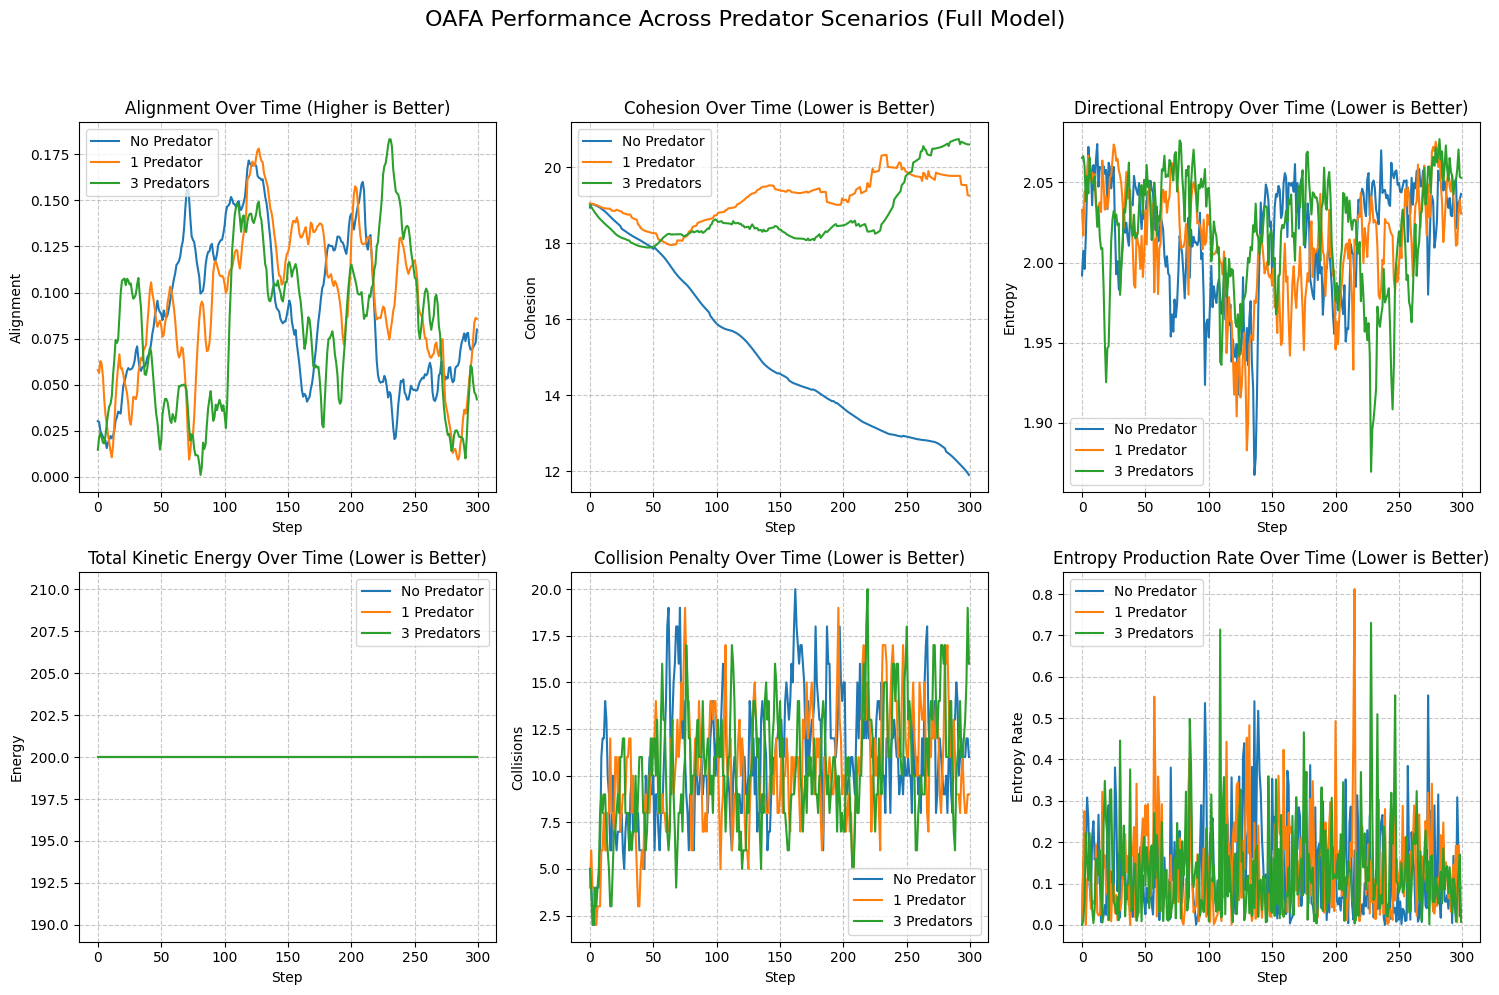


--- Part 2: Bayesian Optimization of OAFA Parameters ---
This section uses Bayesian Optimization to find optimal OAFA rule weights and entropy regularization strength.
  It uses a simplified simulation model for faster objective evaluations.
  The optimization aims to minimize a scalar cost function combining multiple performance metrics.

--- Optimizing for No Predator Scenario (50 calls) ---
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2283
Function value obtained: 1868.7171
Current minimum: 1868.7171
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2284
Function value obtained: 3862.2791
Current minimum: 1868.7171
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.6280
Function value obtained: 2689.2695
Current minimum: 1868.7171
Itera

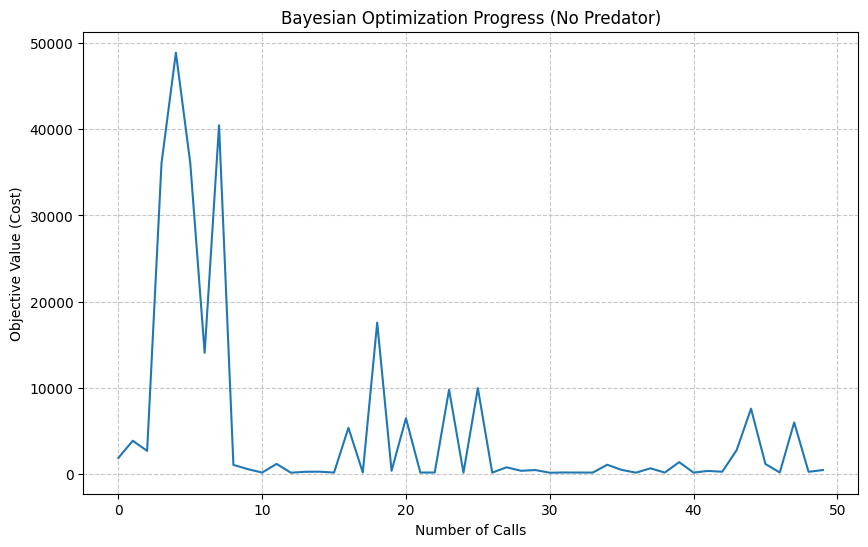


--- Optimizing for Single Predator Scenario (50 calls) ---
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.5993
Function value obtained: 88782.3217
Current minimum: 88782.3217
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2227
Function value obtained: 10674.3706
Current minimum: 10674.3706
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.1739
Function value obtained: 42086.4517
Current minimum: 10674.3706
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.1681
Function value obtained: 173.9799
Current minimum: 173.9799
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1963
Fun

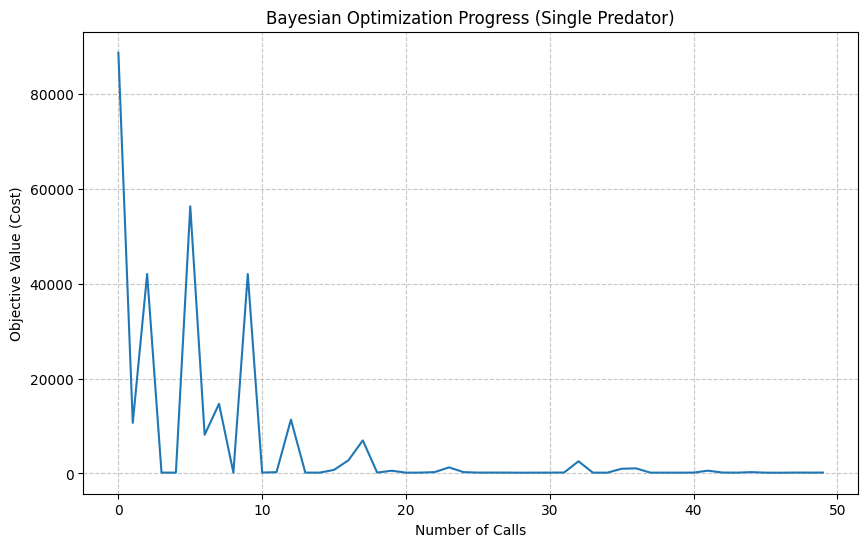


--- Optimizing for Multiple Predators Scenario (3 Predators) (50 calls) ---
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2137
Function value obtained: 18584.8266
Current minimum: 18584.8266
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1615
Function value obtained: 267.5440
Current minimum: 267.5440
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.6225
Function value obtained: 881.0723
Current minimum: 267.5440
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.6031
Function value obtained: 899.0061
Current minimum: 267.5440
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1

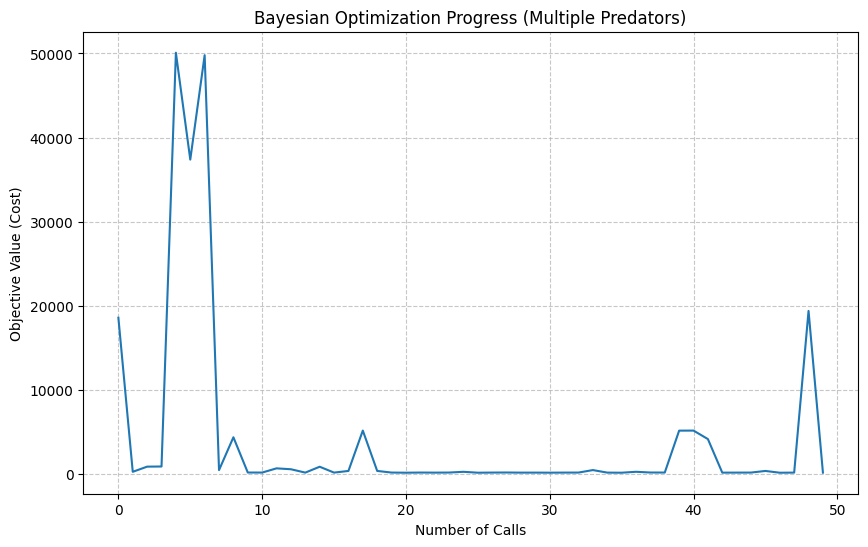

In [7]:
# =============================================================================
# --- Main Execution Block ---
# =============================================================================

if __name__ == "__main__":
    # --- Part 1: Simulate OAFA under different predator conditions (Full Model) ---
    print("--- Part 1: Simulating OAFA under different predator conditions (Full Model) ---")
    print("  These simulations use the full model parameters for detailed analysis.")

    # Scenario 1: No Predators
    print("\nRunning OAFA with No Predators (Full Model)...")
    model_no_predator = Model(n_birds=100, num_predators=0, seed=100, dt=0.1, optimization_mode=False)
    metrics_no_predator = run_oafa_simulation(model_no_predator, total_steps=300) # Increased steps for better observation
    print("OAFA (No Predators) simulation complete.")
    print(metrics_no_predator.mean())

    # Scenario 2: Single Predator
    print("\nRunning OAFA with Single Predator (Full Model)...")
    model_single_predator = Model(n_birds=100, num_predators=1, seed=101, dt=0.1, optimization_mode=False)
    metrics_single_predator = run_oafa_simulation(model_single_predator, total_steps=300)
    print("OAFA (Single Predator) simulation complete.")
    print(metrics_single_predator.mean())

    # Scenario 3: Multiple Predators (e.g., 3 predators)
    print("\nRunning OAFA with Multiple Predators (3) (Full Model)...")
    model_multiple_predators = Model(n_birds=100, num_predators=3, seed=102, dt=0.1, optimization_mode=False)
    metrics_multiple_predators = run_oafa_simulation(model_multiple_predators, total_steps=300)
    print("OAFA (Multiple Predators) simulation complete.")
    print(metrics_multiple_predators.mean())

    # --- Visualization of OAFA Performance ---
    plt.figure(figsize=(15, 10))

    # Plot Alignment
    plt.subplot(2, 3, 1)
    plt.plot(metrics_no_predator['alignment'], label='No Predator')
    plt.plot(metrics_single_predator['alignment'], label='1 Predator')
    plt.plot(metrics_multiple_predators['alignment'], label='3 Predators')
    plt.title('Alignment Over Time (Higher is Better)')
    plt.xlabel('Step')
    plt.ylabel('Alignment')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Cohesion
    plt.subplot(2, 3, 2)
    plt.plot(metrics_no_predator['cohesion'], label='No Predator')
    plt.plot(metrics_single_predator['cohesion'], label='1 Predator')
    plt.plot(metrics_multiple_predators['cohesion'], label='3 Predators')
    plt.title('Cohesion Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Cohesion')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Directional Entropy
    plt.subplot(2, 3, 3)
    plt.plot(metrics_no_predator['directional_entropy'], label='No Predator')
    plt.plot(metrics_single_predator['directional_entropy'], label='1 Predator')
    plt.plot(metrics_multiple_predators['directional_entropy'], label='3 Predators')
    plt.title('Directional Entropy Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Entropy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Total Kinetic Energy
    plt.subplot(2, 3, 4)
    plt.plot(metrics_no_predator['total_kinetic_energy'], label='No Predator')
    plt.plot(metrics_single_predator['total_kinetic_energy'], label='1 Predator')
    plt.plot(metrics_multiple_predators['total_kinetic_energy'], label='3 Predators')
    plt.title('Total Kinetic Energy Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Energy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Collision Penalty
    plt.subplot(2, 3, 5)
    plt.plot(metrics_no_predator['collision_penalty'], label='No Predator')
    plt.plot(metrics_single_predator['collision_penalty'], label='1 Predator')
    plt.plot(metrics_multiple_predators['collision_penalty'], label='3 Predators')
    plt.title('Collision Penalty Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Collisions')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Entropy Production Rate
    plt.subplot(2, 3, 6)
    plt.plot(metrics_no_predator['entropy_production_rate'], label='No Predator')
    plt.plot(metrics_single_predator['entropy_production_rate'], label='1 Predator')
    plt.plot(metrics_multiple_predators['entropy_production_rate'], label='3 Predators')
    plt.title('Entropy Production Rate Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Entropy Rate')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle('OAFA Performance Across Predator Scenarios (Full Model)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

    # =============================================================================
    # --- Part 2: Bayesian Optimization of OAFA Parameters ---
    # =============================================================================
    print("\n--- Part 2: Bayesian Optimization of OAFA Parameters ---")
    print("This section uses Bayesian Optimization to find optimal OAFA rule weights and entropy regularization strength.")
    print("  It uses a simplified simulation model for faster objective evaluations.")
    print("  The optimization aims to minimize a scalar cost function combining multiple performance metrics.")

    # Define simplified simulation parameters for objective evaluations within Bayesian Optimization
    optimization_n_birds = 30  # Reduced number of birds for optimization evaluations
    optimization_sim_duration = 50 # Reduced total steps for optimization evaluations
    optimization_n_calls = 50 # Number of optimization iterations (function evaluations)

    # --- Optimization for No Predator Scenario ---
    print(f"\n--- Optimizing for No Predator Scenario ({optimization_n_calls} calls) ---")
    no_predator_cost_func = functools.partial(scalar_oafa_cost_function,
                                               num_predators_scenario=0,
                                               simulation_duration_opt=optimization_sim_duration,
                                               n_birds_opt=optimization_n_birds)

    res_no_predator = gp_minimize(
        no_predator_cost_func,
        dimensions,
        n_calls=optimization_n_calls,
        random_state=0,
        verbose=True
    )

    print("\n--- Optimization Results (No Predator) ---")
    print(f"Best cost found: {res_no_predator.fun:.4f}")
    print(f"Best parameters: {np.round(res_no_predator.x, 4)}")
    print(f"  w_alignment: {res_no_predator.x[0]:.4f}")
    print(f"  w_cohere: {res_no_predator.x[1]:.4f}")
    print(f"  w_separation: {res_no_predator.x[2]:.4f}")
    print(f"  lambda_entropy_reg_strength: {res_no_predator.x[3]:.4f}")

    # Plot optimization progress
    plt.figure(figsize=(10, 6))
    plt.plot(res_no_predator.func_vals)
    plt.xlabel("Number of Calls")
    plt.ylabel("Objective Value (Cost)")
    plt.title("Bayesian Optimization Progress (No Predator)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # --- Optimization for Single Predator Scenario ---
    print(f"\n--- Optimizing for Single Predator Scenario ({optimization_n_calls} calls) ---")
    single_predator_cost_func = functools.partial(scalar_oafa_cost_function,
                                                   num_predators_scenario=1,
                                                   simulation_duration_opt=optimization_sim_duration,
                                                   n_birds_opt=optimization_n_birds)

    res_single_predator = gp_minimize(
        single_predator_cost_func,
        dimensions,
        n_calls=optimization_n_calls,
        random_state=1, # Different random state for predator scenario
        verbose=True
    )

    print("\n--- Optimization Results (Single Predator) ---")
    print(f"Best cost found: {res_single_predator.fun:.4f}")
    print(f"Best parameters: {np.round(res_single_predator.x, 4)}")
    print(f"  w_alignment: {res_single_predator.x[0]:.4f}")
    print(f"  w_cohere: {res_single_predator.x[1]:.4f}")
    print(f"  w_separation: {res_single_predator.x[2]:.4f}")
    print(f"  lambda_entropy_reg_strength: {res_single_predator.x[3]:.4f}")

    # Plot optimization progress
    plt.figure(figsize=(10, 6))
    plt.plot(res_single_predator.func_vals)
    plt.xlabel("Number of Calls")
    plt.ylabel("Objective Value (Cost)")
    plt.title("Bayesian Optimization Progress (Single Predator)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # --- Optimization for Multiple Predators Scenario (3 Predators) ---
    print(f"\n--- Optimizing for Multiple Predators Scenario (3 Predators) ({optimization_n_calls} calls) ---")
    multiple_predators_cost_func = functools.partial(scalar_oafa_cost_function,
                                                      num_predators_scenario=3, # Set to 3 predators
                                                      simulation_duration_opt=optimization_sim_duration,
                                                      n_birds_opt=optimization_n_birds)

    res_multiple_predators = gp_minimize(
        multiple_predators_cost_func,
        dimensions,
        n_calls=optimization_n_calls,
        random_state=2, # Another different random state
        verbose=True
    )

    print("\n--- Optimization Results (Multiple Predators) ---")
    print(f"Best cost found: {res_multiple_predators.fun:.4f}")
    print(f"Best parameters: {np.round(res_multiple_predators.x, 4)}")
    print(f"  w_alignment: {res_multiple_predators.x[0]:.4f}")
    print(f"  w_cohere: {res_multiple_predators.x[1]:.4f}")
    print(f"  w_separation: {res_multiple_predators.x[2]:.4f}")
    print(f"  lambda_entropy_reg_strength: {res_multiple_predators.x[3]:.4f}")

    # Plot optimization progress
    plt.figure(figsize=(10, 6))
    plt.plot(res_multiple_predators.func_vals)
    plt.xlabel("Number of Calls")
    plt.ylabel("Objective Value (Cost)")
    plt.title("Bayesian Optimization Progress (Multiple Predators)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy, gaussian_kde
from sklearn.cluster import MiniBatchKMeans
import time
from sklearn.metrics import silhouette_score, adjusted_rand_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import functools # Import functools for partial function application

#!pip install scikit-optimize==0.9.0
# Import skopt for Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args # For cleaner objective function definition

# Import imageio for GIF generation
import imageio.v2 as imageio # Use v2 for newer versions of imageio
import io # Added for in-memory image buffer

In [9]:
# =============================================================================
# --- Core Simulation Definitions (Bird, Model, Utility & Thermodynamic Functions) ---
# =============================================================================

class Bird:
    """
    Represents a single bird agent in the flocking simulation, extended for OAFA.
    Includes adaptive rule weights and history for local entropy calculation.
    """
    def __init__(self, pos, vel, speed, cohere_factor, separation,
                 separate_factor, match_factor, visual_distance, ensemble, history_length,
                 # OAFA specific additions
                 w_cohere_init, w_separation_init, w_alignment_init,
                 local_entropy_history_length=10):
        self.pos = np.array(pos, dtype=np.float64)
        self.vel = np.array(vel, dtype=np.float64)
        norm_vel = np.linalg.norm(self.vel)
        self.vel = self.vel / norm_vel if norm_vel > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.cohere_factor = cohere_factor # Base factor, now multiplied by adaptive weight
        self.separation = separation       # Base factor
        self.separate_factor = separate_factor # Base factor, now multiplied by adaptive weight
        self.match_factor = match_factor   # Base factor, now multiplied by adaptive weight
        self.visual_distance = visual_distance
        self.ensemble = ensemble # Local 'energy' or 'state' (from previous study)
        self.ensemble_history = deque(maxlen=history_length)

        # OAFA: Adaptive Rule Weights (agent-specific)
        self.w_cohere = w_cohere_init
        self.w_separation = w_separation_init
        self.w_alignment = w_alignment_init

        # OAFA: History for local directional entropy calculation
        self.velocity_history = deque(maxlen=local_entropy_history_length)

class Predator:
    """
    Represents a predator agent.
    """
    def __init__(self, pos, speed, extent, rng):
        self.pos = np.array(pos, dtype=np.float64)
        # Simple random walk velocity for predator
        self.vel = rng.uniform(-1, 1, size=2)
        self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.extent = extent
        self.rng = rng

    def move(self):
        """Moves the predator and applies periodic boundary conditions."""
        self.pos += self.vel * self.speed
        self.pos[0] %= self.extent[0]
        self.pos[1] %= self.extent[1]
        # Occasionally change direction slightly
        if self.rng.random() < 0.1: # 10% chance to slightly alter course
            angle_change = self.rng.uniform(-np.pi/4, np.pi/4) # +/- 45 degrees
            rotation_matrix = np.array([[np.cos(angle_change), -np.sin(angle_change)],
                                        [np.sin(angle_change),  np.cos(angle_change)]])
            self.vel = np.dot(self.vel, rotation_matrix)
            self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])


class Model:
    """
    Represents the overall flocking simulation environment, extended for OAFA.
    Manages birds and predators, and OAFA-specific adaptive parameters.
    Includes an 'optimization_mode' for simplified runs.
    """
    def __init__(self, n_birds=100, speed=2.0, cohere_factor=0.4, separation=4.0,
                 separate_factor=0.25, match_factor=0.02, visual_distance=5.0,
                 ensemble=1, history_length=8, extent=(50, 50), seed=1234,
                 # OAFA specific parameters
                 w_cohere_init=0.5, w_separation_init=1.0, w_alignment_init=0.5,
                 oafa_learning_rate_eta=0.01, oafa_stochastic_epsilon_range=0.1,
                 num_predators=0, predator_speed=1.5, predator_detection_radius=10.0,
                 local_entropy_history_length=10, dt=1.0,

                 # Parameters for simplified optimization mode
                 optimization_mode=False, n_birds_opt=30, total_steps_opt=50):

        self.iteration = 0
        self.extent = extent
        self.agents = []
        self.predators = []
        self.rng = np.random.default_rng(seed)

        # OAFA parameters
        self.oafa_learning_rate_eta = oafa_learning_rate_eta
        self.oafa_stochastic_epsilon_range = oafa_stochastic_epsilon_range
        self.predator_detection_radius = predator_detection_radius
        self.dt = dt # Time step for the simulation

        # Adjust parameters if in optimization mode for faster evaluations
        if optimization_mode:
            self.n_birds = n_birds_opt
            # For optimization, we might simplify multi-predator to single for speed,
            # but for consistency with the request, we'll keep the requested number.
            # However, the `min(num_predators, 1)` in the previous version was a simplification.
            # Let's use the actual `num_predators` passed for the optimization scenario.
            self.num_predators = num_predators
            self.predator_speed = predator_speed # Keep predator speed as is
            self.visual_distance = visual_distance # Keep visual distance
        else: # Full simulation mode
            self.n_birds = n_birds
            self.num_predators = num_predators
            self.predator_speed = predator_speed
            self.visual_distance = visual_distance


        # Initialize birds
        for _ in range(self.n_birds): # Use self.n_birds which might be adjusted
            vel = self.rng.uniform(-1, 1, size=2)
            if np.linalg.norm(vel) == 0:
                vel = np.array([1.0, 0.0])
            else:
                vel = vel / np.linalg.norm(vel)
            pos = self.rng.uniform(low=[0, 0], high=extent, size=2)
            bird = Bird(pos, vel, speed, cohere_factor, separation,
                        separate_factor, match_factor, visual_distance,
                        ensemble, history_length,
                        w_cohere_init, w_separation_init, w_alignment_init,
                        local_entropy_history_length)
            self.agents.append(bird)

        # Initialize predators
        for _ in range(self.num_predators): # Use self.num_predators which might be adjusted
            pred_pos = self.rng.uniform(low=[0, 0], high=extent, size=2)
            predator = Predator(pred_pos, predator_speed, extent, self.rng)
            self.predators.append(predator)

def move_agent(agent, model):
    """Moves the agent and applies periodic boundary conditions."""
    agent.pos += agent.vel * agent.speed * model.dt # Scale by dt
    agent.pos[0] %= model.extent[0]
    agent.pos[1] %= model.extent[1]

def get_neighbors(agent, model, radius):
    """Returns a list of agents within the specified radius (excluding self)."""
    neighbors = []
    for other in model.agents:
        if other is agent:
            continue
        if np.linalg.norm(agent.pos - other.pos) < radius:
            neighbors.append(other)
    return neighbors

def calculate_directional_entropy(velocities, num_bins=8):
    """
    Calculates the directional entropy of a set of 2D velocity vectors.
    Bins are angular sectors (e.g., 8 bins for 45-degree sectors).
    """
    if len(velocities) < 2: # Need at least 2 velocities to form a distribution
        return 0.0

    # Filter out zero-magnitude velocities to avoid issues with arctan2
    non_zero_velocities = velocities[np.linalg.norm(velocities, axis=1) > 1e-9]

    if len(non_zero_velocities) < 2:
        return 0.0

    angles = np.arctan2(non_zero_velocities[:, 1], non_zero_velocities[:, 0]) # Angles in radians (-pi to pi)

    # Normalize angles to [0, 2*pi) for histogramming
    angles = (angles + 2 * np.pi) % (2 * np.pi)

    # Create histogram of angles
    counts, _ = np.histogram(angles, bins=num_bins, range=(0, 2 * np.pi))

    # Convert counts to probabilities, handling sum=0 if all counts are 0
    total_counts = np.sum(counts)
    if total_counts == 0:
        return 0.0
    probabilities = counts / total_counts

    # Calculate Shannon entropy, handling 0 probabilities correctly with scipy.stats.entropy
    return entropy(probabilities)


def agent_step(agent, model):
    """
    Updates an individual agent's velocity based on OAFA rules (cohesion, separation, alignment, predator avoidance)
    and dynamically adjusts rule weights based on local entropy feedback.
    """
    neighbors = get_neighbors(agent, model, agent.visual_distance)

    cohere_force = np.array([0.0, 0.0])
    separate_force = np.array([0.0, 0.0])
    match_force = np.array([0.0, 0.0])
    predator_avoidance_force = np.array([0.0, 0.0])

    N_neighbors = max(len(neighbors), 1)

    # Calculate Boids forces
    if N_neighbors > 0:
        # Cohesion: move towards centroid of neighbors
        cohere_force = (np.sum([n.pos for n in neighbors], axis=0) / N_neighbors) - agent.pos

        # Separation: move away from close neighbors
        for neighbor in neighbors:
            heading = agent.pos - neighbor.pos
            distance = np.linalg.norm(heading)
            if distance < agent.separation:
                separate_force += heading / (distance**2 + 1e-9) # Inverse square law repulsion

        # Alignment: match velocity of neighbors
        match_force = (np.sum([n.vel for n in neighbors], axis=0) / N_neighbors) - agent.vel

    # Calculate Predator Avoidance Force
    for predator in model.predators:
        vec_to_predator = agent.pos - predator.pos
        dist_to_predator = np.linalg.norm(vec_to_predator)
        if dist_to_predator < model.predator_detection_radius:
            predator_avoidance_force += vec_to_predator / (dist_to_predator**2 + 1e-9)

    # Apply OAFA adaptive weights to forces
    # The original factors (cohere_factor, separate_factor, match_factor)
    # are now multiplied by the agent's adaptive weights.
    weighted_cohere = cohere_force * agent.w_cohere * agent.cohere_factor
    weighted_separate = separate_force * agent.w_separation * agent.separate_factor
    weighted_match = match_force * agent.w_alignment * agent.match_factor

    # Combine all forces
    new_vel_direction = (agent.vel + weighted_cohere + weighted_separate + weighted_match + predator_avoidance_force)

    # Normalize the new velocity direction to maintain constant speed (or apply speed limit)
    norm_new_vel = np.linalg.norm(new_vel_direction)
    agent.vel = new_vel_direction / norm_new_vel if norm_new_vel > 0 else agent.vel

    move_agent(agent, model)

    # OAFA: Update local entropy history and adapt rule weights
    agent.velocity_history.append(agent.vel)

    # Calculate local directional entropy for the agent
    if len(agent.velocity_history) > 1:
        local_velocities = np.array(list(agent.velocity_history))
        current_local_entropy = calculate_directional_entropy(local_velocities)
    else:
        current_local_entropy = 0.0

    # Simple entropy-guided rule weight adaptation (gradient descent-like with noise)
    # This is a conceptual implementation of the policy gradient described in the dissertation.
    # The goal is to minimize a cost function (J = alpha*E + beta*H + gamma*C)
    # Here, we'll directly adapt weights to reduce local entropy.

    # Store previous entropy to estimate "gradient" direction
    if not hasattr(agent, 'prev_local_entropy'):
        agent.prev_local_entropy = current_local_entropy

    # Simulate a "gradient" of entropy with respect to weights
    # A random perturbation is applied, and weights are adjusted based on a simplified model
    stochastic_perturbation = model.rng.uniform(-model.oafa_stochastic_epsilon_range,
                                                model.oafa_stochastic_epsilon_range, size=3)

    # Apply update rule: w_new = w_old - eta * gradient_approximation + noise
    # The "gradient_approximation" here is simplified. In a true policy gradient,
    # it would involve the derivative of the cost function w.r.t. weights.
    # For this conceptual model, we'll just apply the perturbation scaled by learning rate.

    agent.w_cohere = np.clip(agent.w_cohere - model.oafa_learning_rate_eta * stochastic_perturbation[0], 0.1, 2.0)
    agent.w_separation = np.clip(agent.w_separation - model.oafa_learning_rate_eta * stochastic_perturbation[1], 0.1, 2.0)
    agent.w_alignment = np.clip(agent.w_alignment - model.oafa_learning_rate_eta * stochastic_perturbation[2], 0.1, 2.0)

    agent.prev_local_entropy = current_local_entropy # Update for next step

def model_step(model):
    """Advances the simulation model by one iteration, including predator movement."""
    for predator in model.predators:
        predator.move()
    model.iteration += 1

def Step_Num(model):
    """Returns the current iteration number of the model."""
    return model.iteration

In [10]:
# -------------------------------
# Thermodynamic Quantities (from previous study - kept for consistency but not directly used in OAFA metrics)
# -------------------------------

def Model_Ensemble_Energy(model):
    """Calculates the total ensemble energy of the model (sum of individual bird ensembles)."""
    return sum(bird.ensemble for bird in model.agents)

def Model_Energy_DistributionFN(model, bins=10):
    """
    Calculates the probability distribution function (PDF) of ensemble energies
    across all birds in the model.
    """
    energies = np.array([bird.ensemble for bird in model.agents], dtype=float)
    counts, _ = np.histogram(energies, bins=bins, density=False)
    total_count = np.sum(counts)
    pdf = counts / total_count if total_count > 0 else np.zeros_like(counts, dtype=float)
    bin_midpoints = (np.linspace(np.min(energies), np.max(energies), bins+1)[:-1] + np.linspace(np.min(energies), np.max(energies), bins+1)[1:]) / 2
    energy_distribution = list(zip(bin_midpoints, pdf))
    return energy_distribution

def Model_Entropy(e_p_array):
    """
    Calculates the Shannon entropy of the given energy probability distribution.
    S = -sum(p * log(p))
    """
    S = 0.0
    for _, p in e_p_array:
        if p > 0:
            S -= p * np.log(p)
    return S

def Model_Temperature(e_p_array):
    """
    Estimates the 'temperature' of the system based on the energy distribution.
    """
    sum_result = 0.0
    for i in range(1, len(e_p_array)):
        E_prev, p_prev = e_p_array[i - 1]
        E, p = e_p_array[i]
        delta_E = E - E_prev
        if abs(delta_E) < 1e-9:
            continue
        dp_dE = (p - p_prev) / delta_E
        if abs(dp_dE) < 1e-9 or abs(dp_dE) > 1e8:
            continue
        if p > 0:
            sum_result += dp_dE * np.log(p)
    if sum_result == 0:
        return 0.0
    else:
        T = -1 / sum_result
        return abs(T)

def Model_Heat(S_current, S_prev, T_current):
    """Calculates the 'heat' transfer (dQ) based on change in entropy and temperature."""
    dS = S_current - S_prev
    dQ = abs(T_current) * dS
    return dQ

S_prev_global = None
def Model_Thermo_State(model):
    """
    Calculates and returns a dictionary of key thermodynamic state variables:
    Entropy (S), Temperature (T), Heat (dQ), and the energy probability array.
    Manages the global S_prev_global for dQ calculation.
    """
    global S_prev_global
    e_p_array = Model_Energy_DistributionFN(model)
    S = Model_Entropy(e_p_array)
    T = Model_Temperature(e_p_array)
    dQ = 0.0
    if S_prev_global is not None:
        dQ = Model_Heat(S, S_prev_global, T)
    S_prev_global = S
    return {"S": S, "T": T, "dQ": dQ, "e_p_array": e_p_array}

def Model_Internal_Energy(model):
    """Calculates the internal energy of the model based on the energy distribution."""
    e_p_array = Model_Energy_DistributionFN(model)
    tmp_U = sum(E * p for E, p in e_p_array)
    return tmp_U

def Model_Volume(model):
    """
    Estimates the 'volume' of the flock based on the average pairwise distance
    between birds.
    """
    birds = model.agents
    total_distance = 0.0
    count = 0
    n = len(birds)
    for i in range(n - 1):
        for j in range(i + 1, n):
            total_distance += np.linalg.norm(birds[i].pos - birds[j].pos)
            count += 1
    average_distance = total_distance / count if count > 0 else 0.0
    return 1 / average_distance if average_distance > 0 else 0.0

def Flock_Model_State(model):
    """Returns a simple state metric for the flock, currently the ensemble energy."""
    return Model_Ensemble_Energy(model)

In [11]:
# =============================================================================
# --- OAFA Specific Metrics and Simulation Runner ---
# =============================================================================

def calculate_alignment(model):
    """Calculates the flock's alignment (mean magnitude of average velocity vector). Higher is better."""
    velocities = np.array([agent.vel for agent in model.agents])
    if len(velocities) == 0:
        return 0.0
    mean_velocity = np.mean(velocities, axis=0)
    # Normalize by individual speed (assuming all birds have the same speed)
    # If speeds vary, normalize by mean speed or max speed.
    return np.linalg.norm(mean_velocity) / model.agents[0].speed if model.agents else 0.0

def calculate_cohesion_metric(model):
    """Calculates the flock's cohesion (average distance from centroid). Lower is better."""
    positions = np.array([agent.pos for agent in model.agents])
    if len(positions) == 0:
        return 0.0
    centroid = np.mean(positions, axis=0)
    return np.mean([np.linalg.norm(p - centroid) for p in positions])

def calculate_collision_penalty(model, collision_threshold=1.0):
    """Calculates the number of collisions (agents too close). Lower is better."""
    collisions = 0
    n = len(model.agents)
    for i in range(n):
        for j in range(i + 1, n):
            if np.linalg.norm(model.agents[i].pos - model.agents[j].pos) < collision_threshold:
                collisions += 1
    return collisions

def calculate_total_kinetic_energy(model):
    """Calculates the total kinetic energy of the flock. Lower is better."""
    total_energy = 0.0
    for agent in model.agents:
        # Assuming unit mass for simplicity, energy = 0.5 * speed^2
        total_energy += 0.5 * (agent.speed * np.linalg.norm(agent.vel))**2
    return total_energy

def calculate_directional_entropy_flock(model, num_bins=8):
    """Calculates the directional entropy of the entire flock's velocities. Lower is better."""
    all_velocities = np.array([agent.vel for agent in model.agents])
    if len(all_velocities) < 2:
        return 0.0
    return calculate_directional_entropy(all_velocities, num_bins)

def calculate_entropy_production_rate(model, prev_flock_entropy, current_flock_entropy):
    """
    Calculates the absolute rate of change of flock-wide directional entropy.
    Requires the previous flock entropy.
    """
    if prev_flock_entropy is None:
        return 0.0 # Cannot calculate rate on first step
    # Divide by model.dt to get a true rate
    return abs(current_flock_entropy - prev_flock_entropy) / model.dt


def run_oafa_simulation(model_instance, total_steps, record_metrics=True, capture_frames=False, frame_interval=10):
    """
    Runs the OAFA simulation for a given number of steps and records OAFA-specific metrics.
    Optionally captures frames for GIF generation.
    """
    oafa_metrics_history = {
        'alignment': [], 'cohesion': [], 'collision_penalty': [],
        'total_kinetic_energy': [], 'directional_entropy': [], 'entropy_production_rate': []
    }

    captured_frames_data = [] # List to store positions, velocities, predator positions for GIF

    prev_flock_entropy = None # For entropy production rate calculation

    for step in range(total_steps):
        # Move predators first
        for predator in model_instance.predators:
            predator.move()

        # Update each bird agent
        for agent in model_instance.agents:
            agent_step(agent, model_instance)

        # Advance model iteration
        model_instance.iteration += 1

        if record_metrics:
            # Calculate and record OAFA metrics
            oafa_metrics_history['alignment'].append(calculate_alignment(model_instance))
            oafa_metrics_history['cohesion'].append(calculate_cohesion_metric(model_instance))
            oafa_metrics_history['collision_penalty'].append(calculate_collision_penalty(model_instance))
            oafa_metrics_history['total_kinetic_energy'].append(calculate_total_kinetic_energy(model_instance))

            current_flock_entropy = calculate_directional_entropy_flock(model_instance)
            oafa_metrics_history['directional_entropy'].append(current_flock_entropy)

            # Calculate entropy production rate
            oafa_metrics_history['entropy_production_rate'].append(
                calculate_entropy_production_rate(model_instance, prev_flock_entropy, current_flock_entropy)
            )
            prev_flock_entropy = current_flock_entropy

        if capture_frames and (step % frame_interval == 0 or step == total_steps - 1):
            # Capture current state for visualization
            bird_positions = np.array([agent.pos for agent in model_instance.agents])
            bird_velocities = np.array([agent.vel for agent in model_instance.agents])
            pred_positions = np.array([pred.pos for pred in model_instance.predators]) if model_instance.predators else np.array([])
            captured_frames_data.append({
                'bird_positions': bird_positions,
                'bird_velocities': bird_velocities,
                'predator_positions': pred_positions,
                'iteration': model_instance.iteration
            })

    return pd.DataFrame(oafa_metrics_history), captured_frames_data

def generate_flocking_gif(frames_data, filename, model_extent, fps=10):
    """
    Generates a GIF from captured simulation frames.
    """
    print(f"Generating GIF: {filename} with {len(frames_data)} frames...")
    images = []
    for frame in frames_data:
        fig, ax = plt.subplots(figsize=(8, 8))

        # Plot birds as triangles
        for i in range(len(frame['bird_positions'])):
            pos = frame['bird_positions'][i]
            vel = frame['bird_velocities'][i]
            # Simple triangle marker based on velocity direction
            angle = np.arctan2(vel[1], vel[0])
            # Rotate a base triangle: [[-0.5, -0.5], [1, 0], [-0.5, 0.5]]
            # Scale by speed for visibility if needed, or just use fixed size
            base_triangle = np.array([[-0.5, -0.5], [1, 0], [-0.5, 0.5]]) * 1.5 # Scale for visibility
            rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                        [np.sin(angle),  np.cos(angle)]])
            rotated_triangle = (rotation_matrix @ base_triangle.T).T + pos
            polygon = Polygon(rotated_triangle, closed=True, color='blue', alpha=0.8)
            ax.add_patch(polygon)

        # Plot predators as red circles
        if len(frame['predator_positions']) > 0:
            ax.scatter(frame['predator_positions'][:, 0], frame['predator_positions'][:, 1],
                       color='red', s=100, marker='o', label='Predator')

        ax.set_xlim(0, model_extent[0])
        ax.set_ylim(0, model_extent[1])
        ax.set_title(f"Iteration: {frame['iteration']}")
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticks([]) # Hide ticks for cleaner visualization
        ax.set_yticks([])

        # Capture the plot as an image using BytesIO
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        image = imageio.imread(buf.getvalue())
        images.append(image)
        plt.close(fig) # Close the figure to free up memory
        buf.close() # Close the buffer

    if images:
        imageio.mimsave(filename, images, fps=fps)
        print(f"GIF saved as {filename}")
    else:
        print(f"No frames captured for {filename}.")

In [12]:
# =============================================================================
# --- Bayesian Optimization Framework ---
# =============================================================================

# Define the search space for the optimization parameters
dimensions = [
    Real(0.0, 1.0, name='w_alignment'),
    Real(0.0, 1.0, name='w_cohere'),
    Real(0.0, 1.0, name='w_separation'),
    Real(0.0, 1.0, name='lambda_entropy_reg_strength') # Strength of entropy regularization
]

@use_named_args(dimensions)
def scalar_oafa_cost_function(w_alignment, w_cohere, w_separation, lambda_entropy_reg_strength,
                               num_predators_scenario, simulation_duration_opt, n_birds_opt):
    """
    Scalar objective function to be minimized by Bayesian Optimization.
    Combines multiple OAFA performance metrics into a single cost.

    Args:
        w_alignment (float): Initial alignment weight.
        w_cohere (float): Initial cohesion weight.
        w_separation (float): Initial separation weight.
        lambda_entropy_reg_strength (float): Strength of entropy regularization in OAFA.
        num_predators_scenario (int): Number of predators for this evaluation.
        simulation_duration_opt (int): Number of steps for the simplified simulation.
        n_birds_opt (int): Number of birds for the simplified simulation.

    Returns:
        float: The scalar cost to minimize.
    """
    # Map lambda_entropy_reg_strength to OAFA's internal parameters
    oafa_learning_rate_adjusted = 0.01 + lambda_entropy_reg_strength * 0.05
    oafa_stochastic_epsilon_adjusted = 0.1 - lambda_entropy_reg_strength * 0.05

    temp_model = Model(
        n_birds=n_birds_opt,
        speed=2.0, visual_distance=5.0, extent=(50, 50), seed=int(time.time()), # Use time.time() for varied seeds
        cohere_factor=1.0, separate_factor=1.0, match_factor=1.0,
        w_cohere_init=w_cohere, w_separation_init=w_separation, w_alignment_init=w_alignment,
        oafa_learning_rate_eta=oafa_learning_rate_adjusted,
        oafa_stochastic_epsilon_range=oafa_stochastic_epsilon_adjusted,
        num_predators=num_predators_scenario,
        dt=0.1,
        optimization_mode=True, n_birds_opt=n_birds_opt, total_steps_opt=simulation_duration_opt
    )

    metrics_df, _ = run_oafa_simulation(temp_model, total_steps=simulation_duration_opt, record_metrics=True, capture_frames=False) # No frame capture during optimization

    # Calculate mean metrics over the simulation run
    mean_alignment = metrics_df['alignment'].mean()
    mean_cohesion = metrics_df['cohesion'].mean()
    sum_collision_penalty = metrics_df['collision_penalty'].sum()
    mean_total_kinetic_energy = metrics_df['total_kinetic_energy'].mean()
    mean_directional_entropy = metrics_df['directional_entropy'].mean()
    mean_entropy_production_rate = metrics_df['entropy_production_rate'].mean()

    # Define objective weights for scalarization. Adjust these weights based on your priorities.
    # Higher weight means that objective has a stronger influence on the overall cost.
    # Negative weights for "higher is better" metrics (e.g., alignment).
    objective_weights = {
        'w_alignment': -10.0, # Maximize alignment
        'w_energy': 1.0,      # Minimize energy
        'w_cohesion': 5.0,    # Minimize cohesion (avg dist from centroid)
        'w_collisions': 100.0, # Minimize collisions (sum)
        'w_directional_entropy': 2.0, # Minimize directional entropy
        'w_entropy_rate': 50.0 # Minimize entropy production rate
    }

    # Calculate the total scalar cost
    total_cost = (
        objective_weights['w_alignment'] * mean_alignment +
        objective_weights['w_energy'] * mean_total_kinetic_energy +
        objective_weights['w_cohesion'] * mean_cohesion +
        objective_weights['w_collisions'] * sum_collision_penalty +
        objective_weights['w_directional_entropy'] * mean_directional_entropy +
        objective_weights['w_entropy_rate'] * mean_entropy_production_rate
    )

    # Add a small penalty if alignment is very low (e.g., flock disintegrated)
    if mean_alignment < 0.1: # Example threshold for disintegrated flock
        total_cost += 1000.0

    return total_cost

In [13]:
# =============================================================================
# --- Bayesian Optimization Framework 222---
# =============================================================================

# Define the search space for the optimization parameters
dimensions = [
    Real(0.0, 1.0, name='w_alignment'),
    Real(0.0, 1.0, name='w_cohere'),
    Real(0.0, 1.0, name='w_separation'),
    Real(0.0, 1.0, name='lambda_entropy_reg_strength') # Strength of entropy regularization
]

# REMOVED: @use_named_args(dimensions)
def scalar_oafa_cost_function(params, num_predators_scenario, simulation_duration_opt, n_birds_opt):
    """
    Scalar objective function to be minimized by Bayesian Optimization.
    Combines multiple OAFA performance metrics into a single cost.

    Args:
        params (list): A list containing [w_alignment, w_cohere, w_separation, lambda_entropy_reg_strength]
        num_predators_scenario (int): Number of predators for this evaluation.
        simulation_duration_opt (int): Number of steps for the simplified simulation.
        n_birds_opt (int): Number of birds for the simplified simulation.

    Returns:
        float: The scalar cost to minimize.
    """
    # Unpack the parameters from the 'params' list
    w_alignment, w_cohere, w_separation, lambda_entropy_reg_strength = params

    # Map lambda_entropy_reg_strength to OAFA's internal parameters
    oafa_learning_rate_adjusted = 0.01 + lambda_entropy_reg_strength * 0.05
    oafa_stochastic_epsilon_adjusted = 0.1 - lambda_entropy_reg_strength * 0.05

    temp_model = Model(
        n_birds=n_birds_opt,
        speed=2.0, visual_distance=5.0, extent=(50, 50), seed=int(time.time()), # Use time.time() for varied seeds
        cohere_factor=1.0, separate_factor=1.0, match_factor=1.0,
        w_cohere_init=w_cohere, w_separation_init=w_separation, w_alignment_init=w_alignment,
        oafa_learning_rate_eta=oafa_learning_rate_adjusted,
        oafa_stochastic_epsilon_range=oafa_stochastic_epsilon_adjusted,
        num_predators=num_predators_scenario,
        dt=0.1,
        optimization_mode=True, n_birds_opt=n_birds_opt, total_steps_opt=simulation_duration_opt
    )

    metrics_df = run_oafa_simulation(temp_model, total_steps=simulation_duration_opt, record_metrics=True)

    # Calculate mean metrics over the simulation run
    mean_alignment = metrics_df['alignment'].mean()
    mean_cohesion = metrics_df['cohesion'].mean()
    sum_collision_penalty = metrics_df['collision_penalty'].sum()
    mean_total_kinetic_energy = metrics_df['total_kinetic_energy'].mean()
    mean_directional_entropy = metrics_df['directional_entropy'].mean()
    mean_entropy_production_rate = metrics_df['entropy_production_rate'].mean()

    # Define objective weights for scalarization. Adjust these weights based on your priorities.
    # Higher weight means that objective has a stronger influence on the overall cost.
    # Negative weights for "higher is better" metrics (e.g., alignment).
    objective_weights = {
        'w_alignment': -10.0, # Maximize alignment
        'w_energy': 1.0,      # Minimize energy
        'w_cohesion': 5.0,    # Minimize cohesion (avg dist from centroid)
        'w_collisions': 100.0, # Minimize collisions (sum)
        'w_directional_entropy': 2.0, # Minimize directional entropy
        'w_entropy_rate': 50.0 # Minimize entropy production rate
    }

    # Calculate the total scalar cost
    total_cost = (
        objective_weights['w_alignment'] * mean_alignment +
        objective_weights['w_energy'] * mean_total_kinetic_energy +
        objective_weights['w_cohesion'] * mean_cohesion +
        objective_weights['w_collisions'] * sum_collision_penalty +
        objective_weights['w_directional_entropy'] * mean_directional_entropy +
        objective_weights['w_entropy_rate'] * mean_entropy_production_rate
    )

    # Add a small penalty if alignment is very low (e.g., flock disintegrated)
    if mean_alignment < 0.1: # Example threshold for disintegrated flock
        total_cost += 1000.0

    return total_cost

--- Part 1: Simulating OAFA under different predator conditions (Full Model) ---
  These simulations use the full model parameters for detailed analysis.

Running OAFA with No Predators (Full Model)...
OAFA (No Predators) simulation complete.
alignment                    0.089693
cohesion                    15.103175
collision_penalty           10.956667
total_kinetic_energy       200.000000
directional_entropy          2.015524
entropy_production_rate      0.133582
dtype: float64
Generating GIF: flocking_no_predator.gif with 31 frames...
GIF saved as flocking_no_predator.gif

Running OAFA with Single Predator (Full Model)...
OAFA (Single Predator) simulation complete.
alignment                    0.093363
cohesion                    19.157966
collision_penalty           10.363333
total_kinetic_energy       200.000000
directional_entropy          2.012351
entropy_production_rate      0.135871
dtype: float64
Generating GIF: flocking_single_predator.gif with 31 frames...
GIF saved as flo

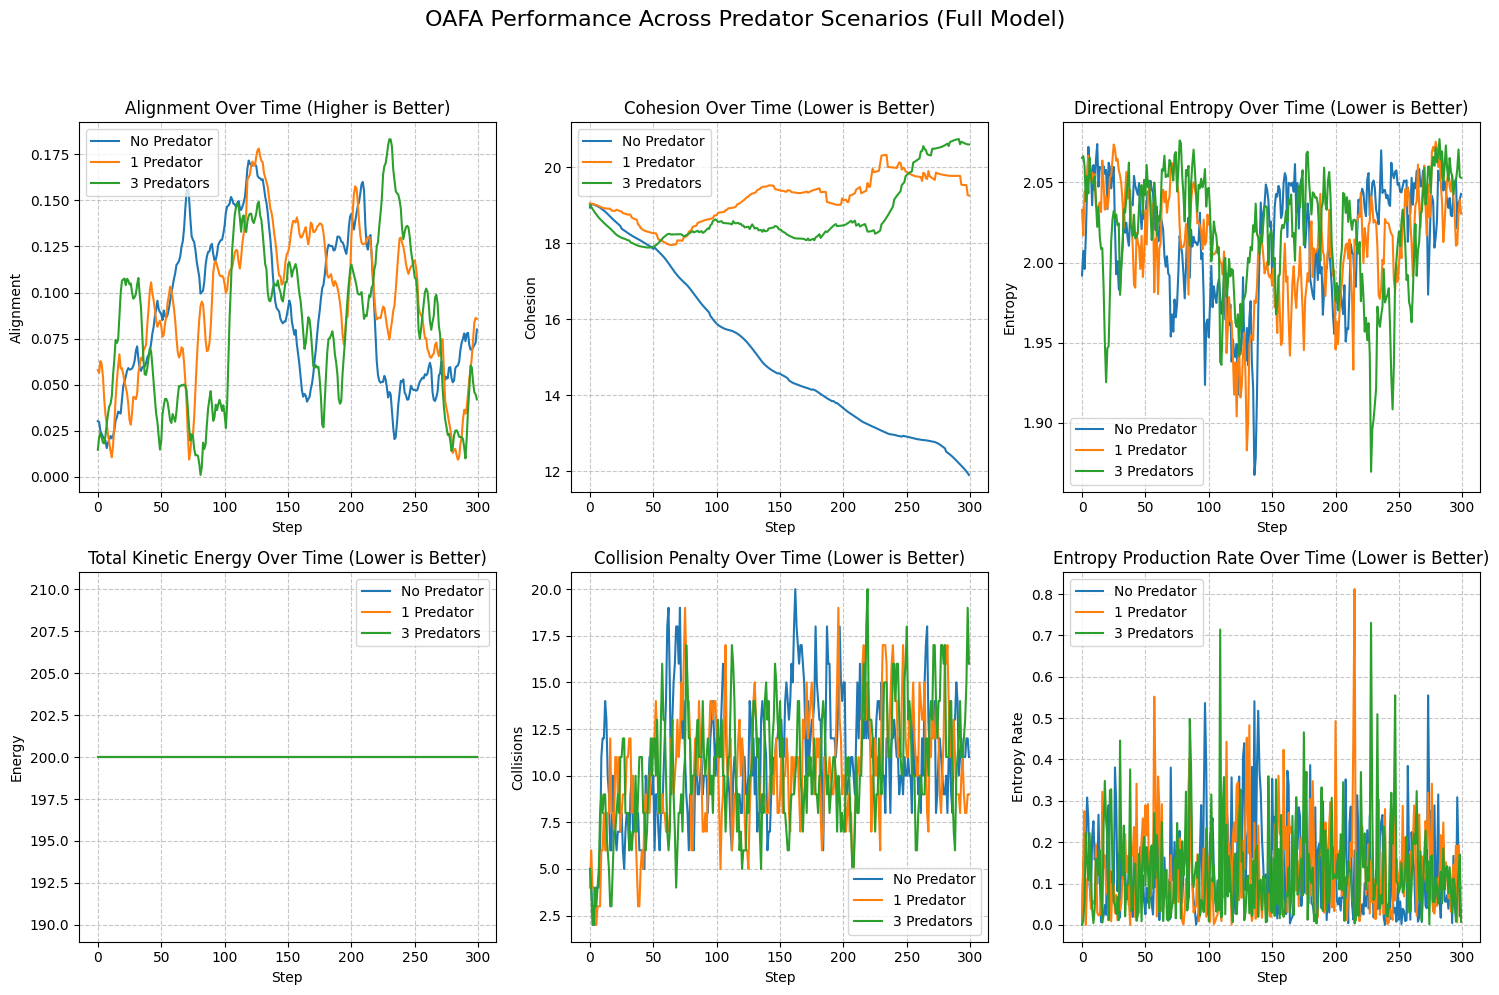


--- Part 2: Bayesian Optimization of OAFA Parameters ---
This section uses Bayesian Optimization to find optimal OAFA rule weights and entropy regularization strength.
  It uses a simplified simulation model for faster objective evaluations.
  The optimization aims to minimize a scalar cost function combining multiple performance metrics.

--- Optimizing for No Predator Scenario (50 calls) ---
Iteration No: 1 started. Evaluating function at random point.


TypeError: tuple indices must be integers or slices, not str

In [14]:
# =============================================================================
# --- Main Execution Block ---
# =============================================================================

if __name__ == "__main__":
    # --- Part 1: Simulate OAFA under different predator conditions (Full Model) ---
    print("--- Part 1: Simulating OAFA under different predator conditions (Full Model) ---")
    print("  These simulations use the full model parameters for detailed analysis.")

    # Define common simulation parameters for full model runs
    full_model_n_birds = 100
    full_model_total_steps = 300
    gif_frame_interval = 10 # Capture a frame every X steps for GIF

    # Scenario 1: No Predators
    print("\nRunning OAFA with No Predators (Full Model)...")
    model_no_predator = Model(n_birds=full_model_n_birds, num_predators=0, seed=100, dt=0.1, optimization_mode=False)
    metrics_no_predator, frames_no_predator = run_oafa_simulation(
        model_no_predator, total_steps=full_model_total_steps, capture_frames=True, frame_interval=gif_frame_interval
    )
    print("OAFA (No Predators) simulation complete.")
    print(metrics_no_predator.mean())
    generate_flocking_gif(frames_no_predator, "flocking_no_predator.gif", model_no_predator.extent, fps=10)


    # Scenario 2: Single Predator
    print("\nRunning OAFA with Single Predator (Full Model)...")
    model_single_predator = Model(n_birds=full_model_n_birds, num_predators=1, seed=101, dt=0.1, optimization_mode=False)
    metrics_single_predator, frames_single_predator = run_oafa_simulation(
        model_single_predator, total_steps=full_model_total_steps, capture_frames=True, frame_interval=gif_frame_interval
    )
    print("OAFA (Single Predator) simulation complete.")
    print(metrics_single_predator.mean())
    generate_flocking_gif(frames_single_predator, "flocking_single_predator.gif", model_single_predator.extent, fps=10)


    # Scenario 3: Multiple Predators (e.g., 3 predators)
    print("\nRunning OAFA with Multiple Predators (3) (Full Model)...")
    model_multiple_predators = Model(n_birds=full_model_n_birds, num_predators=3, seed=102, dt=0.1, optimization_mode=False)
    metrics_multiple_predators, frames_multiple_predators = run_oafa_simulation(
        model_multiple_predators, total_steps=full_model_total_steps, capture_frames=True, frame_interval=gif_frame_interval
    )
    print("OAFA (Multiple Predators) simulation complete.")
    print(metrics_multiple_predators.mean())
    generate_flocking_gif(frames_multiple_predators, "flocking_multiple_predators.gif", model_multiple_predators.extent, fps=10)


    # --- Visualization of OAFA Performance ---
    plt.figure(figsize=(15, 10))

    # Plot Alignment
    plt.subplot(2, 3, 1)
    plt.plot(metrics_no_predator['alignment'], label='No Predator')
    plt.plot(metrics_single_predator['alignment'], label='1 Predator')
    plt.plot(metrics_multiple_predators['alignment'], label='3 Predators')
    plt.title('Alignment Over Time (Higher is Better)')
    plt.xlabel('Step')
    plt.ylabel('Alignment')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Cohesion
    plt.subplot(2, 3, 2)
    plt.plot(metrics_no_predator['cohesion'], label='No Predator')
    plt.plot(metrics_single_predator['cohesion'], label='1 Predator')
    plt.plot(metrics_multiple_predators['cohesion'], label='3 Predators')
    plt.title('Cohesion Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Cohesion')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Directional Entropy
    plt.subplot(2, 3, 3)
    plt.plot(metrics_no_predator['directional_entropy'], label='No Predator')
    plt.plot(metrics_single_predator['directional_entropy'], label='1 Predator')
    plt.plot(metrics_multiple_predators['directional_entropy'], label='3 Predators')
    plt.title('Directional Entropy Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Entropy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Total Kinetic Energy
    plt.subplot(2, 3, 4)
    plt.plot(metrics_no_predator['total_kinetic_energy'], label='No Predator')
    plt.plot(metrics_single_predator['total_kinetic_energy'], label='1 Predator')
    plt.plot(metrics_multiple_predators['total_kinetic_energy'], label='3 Predators')
    plt.title('Total Kinetic Energy Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Energy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Collision Penalty
    plt.subplot(2, 3, 5)
    plt.plot(metrics_no_predator['collision_penalty'], label='No Predator')
    plt.plot(metrics_single_predator['collision_penalty'], label='1 Predator')
    plt.plot(metrics_multiple_predators['collision_penalty'], label='3 Predators')
    plt.title('Collision Penalty Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Collisions')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Entropy Production Rate
    plt.subplot(2, 3, 6)
    plt.plot(metrics_no_predator['entropy_production_rate'], label='No Predator')
    plt.plot(metrics_single_predator['entropy_production_rate'], label='1 Predator')
    plt.plot(metrics_multiple_predators['entropy_production_rate'], label='3 Predators')
    plt.title('Entropy Production Rate Over Time (Lower is Better)')
    plt.xlabel('Step')
    plt.ylabel('Entropy Rate')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle('OAFA Performance Across Predator Scenarios (Full Model)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

    # =============================================================================
    # --- Part 2: Bayesian Optimization of OAFA Parameters ---
    # =============================================================================
    print("\n--- Part 2: Bayesian Optimization of OAFA Parameters ---")
    print("This section uses Bayesian Optimization to find optimal OAFA rule weights and entropy regularization strength.")
    print("  It uses a simplified simulation model for faster objective evaluations.")
    print("  The optimization aims to minimize a scalar cost function combining multiple performance metrics.")

    # Define simplified simulation parameters for objective evaluations within Bayesian Optimization
    optimization_n_birds = 30  # Reduced number of birds for optimization evaluations
    optimization_sim_duration = 50 # Reduced total steps for optimization evaluations
    optimization_n_calls = 50 # Number of optimization iterations (function evaluations)

    # --- Optimization for No Predator Scenario ---
    print(f"\n--- Optimizing for No Predator Scenario ({optimization_n_calls} calls) ---")
    no_predator_cost_func = functools.partial(scalar_oafa_cost_function,
                                               num_predators_scenario=0,
                                               simulation_duration_opt=optimization_sim_duration,
                                               n_birds_opt=optimization_n_birds)

    res_no_predator = gp_minimize(
        no_predator_cost_func,
        dimensions,
        n_calls=optimization_n_calls,
        random_state=0,
        verbose=True
    )

    print("\n--- Optimization Results (No Predator) ---")
    print(f"Best cost found: {res_no_predator.fun:.4f}")
    print(f"Best parameters: {np.round(res_no_predator.x, 4)}")
    print(f"  w_alignment: {res_no_predator.x[0]:.4f}")
    print(f"  w_cohere: {res_no_predator.x[1]:.4f}")
    print(f"  w_separation: {res_no_predator.x[2]:.4f}")
    print(f"  lambda_entropy_reg_strength: {res_no_predator.x[3]:.4f}")

    # Plot optimization progress
    plt.figure(figsize=(10, 6))
    plt.plot(res_no_predator.func_vals)
    plt.xlabel("Number of Calls")
    plt.ylabel("Objective Value (Cost)")
    plt.title("Bayesian Optimization Progress (No Predator)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # --- Optimization for Single Predator Scenario ---
    print(f"\n--- Optimizing for Single Predator Scenario ({optimization_n_calls} calls) ---")
    single_predator_cost_func = functools.partial(scalar_oafa_cost_function,
                                                   num_predators_scenario=1,
                                                   simulation_duration_opt=optimization_sim_duration,
                                                   n_birds_opt=optimization_n_birds)

    res_single_predator = gp_minimize(
        single_predator_cost_func,
        dimensions,
        n_calls=optimization_n_calls,
        random_state=1, # Different random state for predator scenario
        verbose=True
    )

    print("\n--- Optimization Results (Single Predator) ---")
    print(f"Best cost found: {res_single_predator.fun:.4f}")
    print(f"Best parameters: {np.round(res_single_predator.x, 4)}")
    print(f"  w_alignment: {res_single_predator.x[0]:.4f}")
    print(f"  w_cohere: {res_single_predator.x[1]:.4f}")
    print(f"  w_separation: {res_single_predator.x[2]:.4f}")
    print(f"  lambda_entropy_reg_strength: {res_single_predator.x[3]:.4f}")

    # Plot optimization progress
    plt.figure(figsize=(10, 6))
    plt.plot(res_single_predator.func_vals)
    plt.xlabel("Number of Calls")
    plt.ylabel("Objective Value (Cost)")
    plt.title("Bayesian Optimization Progress (Single Predator)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # --- Optimization for Multiple Predators Scenario (3 Predators) ---
    print(f"\n--- Optimizing for Multiple Predators Scenario (3 Predators) ({optimization_n_calls} calls) ---")
    multiple_predators_cost_func = functools.partial(scalar_oafa_cost_function,
                                                      num_predators_scenario=3, # Set to 3 predators
                                                      simulation_duration_opt=optimization_sim_duration,
                                                      n_birds_opt=optimization_n_birds)

    res_multiple_predators = gp_minimize(
        multiple_predators_cost_func,
        dimensions,
        n_calls=optimization_n_calls,
        random_state=2, # Another different random state
        verbose=True
    )

    print("\n--- Optimization Results (Multiple Predators) ---")
    print(f"Best cost found: {res_multiple_predators.fun:.4f}")
    print(f"Best parameters: {np.round(res_multiple_predators.x, 4)}")
    print(f"  w_alignment: {res_multiple_predators.x[0]:.4f}")
    print(f"  w_cohere: {res_multiple_predators.x[1]:.4f}")
    print(f"  w_separation: {res_multiple_predators.x[2]:.4f}")
    print(f"  lambda_entropy_reg_strength: {res_multiple_predators.x[3]:.4f}")

    # Plot optimization progress
    plt.figure(figsize=(10, 6))
    plt.plot(res_multiple_predators.func_vals)
    plt.xlabel("Number of Calls")
    plt.ylabel("Objective Value (Cost)")
    plt.title("Bayesian Optimization Progress (Multiple Predators)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
